## Capstone Project - The Battle of the Neighborhoods

# Location for a new restaurant in Bogotá, Colombia

#### Capstone Project for Applied Data Science Specialization offered by IBM/Coursera

### Table Of Content:
* [Introduction/Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analyisis](#analysis)
* [Results](#results)
* [Conclusions](#conclusions)

### Introduction/Business Problem <a class="anchor" id="introduction"></a>

Through this project we will collect and deliver information that helps our target audience to find the optimal location for a new restaurant in **Bogotá, Colombia**. The results of this analysis are intended to be used by entrepreneurs interested in opening a restaurant of an any given type in one of the 21 _localidades_ (boroughs) of the Colombia's capital city.

In order to deliver valuable information to our target audience, we will identify those city zones where the restaurant and food service industry are already located and what type of restaurants or food business are running. Also, we will identify locations that have not plenty of restaurants already. This way we will provide information so the most promising neighborhoods and the best possible location can be chosen by the entrepreneur. 

### Data <a class="anchor" id="data"></a>

Based on our problem definition, the information described below will be delivered as a result of the analysis:
* number of existing restaurants in every neighbourhood (any type of restaurant)
* number of existing restaurants in every neighbourhood by type/category, if any
* segmentation of neighbourhood by type/category of restaurant or food business

The data sources that will be used to generate the required information:
* geographic information (latitude and longitude) of every neighbourhood of Bogotá city, will be obtained from **Laboratorio Urbano Bogotá API**. API documentation at https://bogota-laburbano.opendatasoft.com/explore/dataset/barrios_prueba/api/
* geographic information (latitude and longitude) of every _localidad_ of Bogotá city, will be obtained from **Laboratorio Urbano Bogotá API**. API documentation at https://bogota-laburbano.opendatasoft.com/explore/dataset/georeferencia-puntual-por-localidad/api/
* number of restaurants/food busines and their type and location in every _localidad_, will be obtained from **Foursquare API**  


Before we get the data necesary for our analysis and start exploring it, we'll download all the packages that we will need. 

In [1]:
# basic libraries for data analsysis
import numpy as np
import pandas as pd

In [2]:
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [3]:
import requests # library to handle requests

In [4]:
# library for geocoding services
from geopy.geocoders import Nominatim

In [5]:
from sklearn.cluster import KMeans # import k-means from clustering analysis

In [6]:
# map rendering library
#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [7]:
# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Downloading and wrangling the data

##### 1. Geographic information of Bogotá's Localidades and Neighbourhoods

First, we will use geopy library to get the latitude and longitude values of Bogotá, as shown below.

In [8]:
geolocator = Nominatim(user_agent="bog_city")
location = geolocator.geocode('Bogotá')
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Bogotá, Colombia are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Bogotá, Colombia are 4.6533326, -74.083652.


Next, from Laboratorio Urbano Bogotá API we get the geographic information (latitud and longitude) for every _Localidad_ in Bogotá.

In [9]:
url_localidades = 'https://bogota-laburbano.opendatasoft.com/api/records/1.0/search/?dataset=georeferencia-puntual-por-localidad&q=&rows=21'
data_localidades  = requests.get(url_localidades).json()

In [10]:
#extracting the relevant part of JSON file and tranforming it into a dataframe
localidades = data_localidades['records']
df_data_localidades = json_normalize(localidades)
df_data_localidades.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,datasetid,recordid,record_timestamp,fields.localidad,fields.latitud,fields.cod,fields.longitud,fields.gp,geometry.type,geometry.coordinates
0,georeferencia-puntual-por-localidad,ddcf1fe3081c909c70ac4b510b5abec8ce8a2fcc,2016-11-01T06:07:10.703000+00:00,BARRIOS UNIDOS,4.666400,12,-74.084000,"[-74.084, 4.6664]",Point,"[4.6664, -74.084]"
1,georeferencia-puntual-por-localidad,3e8fb384bcb276c65f4770c82c18d4a26e42f1c8,2016-11-01T06:07:10.703000+00:00,ENGATIVÁ,4.707100,10,-74.107200,"[-74.1072, 4.7071000000000005]",Point,"[4.7071000000000005, -74.1072]"
2,georeferencia-puntual-por-localidad,e3638db5c4b8cc7dec59dc8b14aa4fb91394141f,2016-11-01T06:07:10.703000+00:00,SUMAPAZ,4.034746,20,-74.315224,"[-74.315224, 4.034746]",Point,"[4.034746, -74.315224]"
3,georeferencia-puntual-por-localidad,0a83bd2e1d302143eb9f7f70379187f0f5afa571,2016-11-01T06:07:10.703000+00:00,TEUSAQUILLO,4.644800,13,-74.093800,"[-74.0938, 4.6448]",Point,"[4.6448, -74.0938]"
4,georeferencia-puntual-por-localidad,39e2d6486e17b6af8b06a7b93284f0742c532aff,2016-11-01T06:07:10.703000+00:00,LA CANDELARIA,4.593900,17,-74.073900,"[-74.0739, 4.5939]",Point,"[4.5939, -74.0739]"


In [11]:
# keeping only columns that include the neighbourhood, localidad name and its location
data_localidades = df_data_localidades[['fields.localidad','fields.latitud','fields.longitud']]

#renaming the columns for simplicity 
data_localidades.columns = ['Localidad', 'Latitude', 'Longitude']
data_localidades['Localidad'] = data_localidades['Localidad'].str.title()
data_localidades.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Localidad,Latitude,Longitude
0,Barrios Unidos,4.666400,-74.084000
1,Engativá,4.707100,-74.107200
2,Sumapaz,4.034746,-74.315224
3,Teusaquillo,4.644800,-74.093800
4,La Candelaria,4.593900,-74.073900


Finally, from **Laboratorio Urbano Bogotá API** we get the geographic information (latitud and longitude) for every Neighbourhood in Bogotá.

In [12]:
url_neighbourhoods = 'https://bogota-laburbano.opendatasoft.com/api/records/1.0/search/?dataset=barrios_prueba&q=&rows=3871'
data_neighbourhoods  = requests.get(url_neighbourhoods).json()

In [13]:
#extracting the relevant part of JSON file and tranforming it into a dataframe
neighbourhoods = data_neighbourhoods['records']
df_data_neighbourhoods = json_normalize(neighbourhoods)
df_data_neighbourhoods.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,datasetid,recordid,record_timestamp,fields.shape_area,fields.objectid,fields.barriocomu,fields.shape_len,fields.geo_point_2d,fields.geo_shape.type,fields.geo_shape.coordinates,fields.localidad,fields.estado,fields.cod_loc,fields.cod_polbar,geometry.type,geometry.coordinates
0,barrios_prueba,d3c02a0a0dee95753764f501e47f3f8334c2fd63,2017-10-04T04:17:53.334000+00:00,5.638930e-06,629,Batavia,0.009591,"[4.685054723072063, -74.15063774750227]",Polygon,"[[[-74.14966256399998, 4.685645380999972], [-7...",Fontibón,SIN LEGALIZAR,9,90008,Point,"[-74.15063774750227, 4.685054723072063]"
1,barrios_prueba,d390d98b6884e9d99aea5f8269b5c3dd3fcd9f4e,2017-10-04T04:17:53.334000+00:00,9.796674e-06,639,Belmira,0.013901,"[4.719587802583845, -74.03016682529241]",Polygon,"[[[-74.02745988599997, 4.719393677000027], [-7...",Usaquén,SIN LEGALIZAR,1,10024,Point,"[-74.03016682529241, 4.719587802583845]"
2,barrios_prueba,f551384c2a768bdcd94c75352b8a4dad62cea58b,2017-10-04T04:17:53.334000+00:00,1.212833e-05,640,Las_Acacias,0.016242,"[4.721537996337589, -74.0295756727155]",Polygon,"[[[-74.02628437099997, 4.721175910999988], [-7...",Usaquén,LEGALIZADO,1,10128,Point,"[-74.0295756727155, 4.721537996337589]"
3,barrios_prueba,69b2f032c5f81ff794de7ae750bbf6d2c6aade73,2017-10-04T04:17:53.334000+00:00,4.258500e-07,660,Carmen del Sol I Sector,0.003019,"[4.5665238147100755, -74.1141540040012]",Polygon,"[[[-74.11358913800001, 4.566485069999998], [-7...",Rafael Uribe,LEGALIZADO,18,180020,Point,"[-74.1141540040012, 4.5665238147100755]"
4,barrios_prueba,44353bad26aa426104ebccc12c1156b3bd8b3852,2017-10-04T04:17:53.334000+00:00,1.018448e-06,665,Urb. Furatena,0.004599,"[4.703728000127343, -74.02776231525299]",Polygon,"[[[-74.02865844399997, 4.703816109999991], [-7...",Usaquén,SIN LEGALIZAR,1,10245,Point,"[-74.02776231525299, 4.703728000127343]"


In [14]:
df_data_neighbourhoods.shape

(3871, 16)

In [15]:
# keeping only columns that include the neighbourhood, localidad name and its location
data_neighbourhoods = df_data_neighbourhoods[['fields.barriocomu','fields.localidad','fields.geo_point_2d']]

In [16]:
#counting the non-null values in the data set
data_neighbourhoods.count()

fields.barriocomu      3871
fields.localidad       3016
fields.geo_point_2d    3868
dtype: int64

In [17]:
# removing any null value from the data, sincewe need the localidad name and the location for every neighbourhood
data_neighbourhoods.dropna(inplace=True)
data_neighbourhoods.shape

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(3014, 3)

In [18]:
# split the geographic coordenates into latitud and longitud
data_neighbourhoods[['Latitude','Longitude']] = pd.DataFrame(data_neighbourhoods['fields.geo_point_2d'].tolist(), index = data_neighbourhoods.index)
data_neighbourhoods.drop(['fields.geo_point_2d'], axis = 1, inplace = True)
data_neighbourhoods.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,fields.barriocomu,fields.localidad,Latitude,Longitude
0,Batavia,Fontibón,4.685055,-74.150638
1,Belmira,Usaquén,4.719588,-74.030167
2,Las_Acacias,Usaquén,4.721538,-74.029576
3,Carmen del Sol I Sector,Rafael Uribe,4.566524,-74.114154
4,Urb. Furatena,Usaquén,4.703728,-74.027762


Now we have the _data_neighbourhoods_ dataframe with the geographical location and the localidad for every neighbourhood

In [19]:
#renaming the columns for simplicity 
data_neighbourhoods.columns = ['Neighbourhood','Localidad', 'Latitude', 'Longitude']
data_neighbourhoods.head()

,Neighbourhood,Localidad,Latitude,Longitude
0,Batavia,Fontibón,4.685055,-74.150638
1,Belmira,Usaquén,4.719588,-74.030167
2,Las_Acacias,Usaquén,4.721538,-74.029576
3,Carmen del Sol I Sector,Rafael Uribe,4.566524,-74.114154
4,Urb. Furatena,Usaquén,4.703728,-74.027762


Since we have a limit for the free calls to the Foursquare API, we will randomly select a sample ot the data for further analysis

In [20]:
data_neighbourhoods = data_neighbourhoods.sample(n = 250, random_state = 1)
data_neighbourhoods.reset_index(inplace= True , drop=True)

Below, we have a Bogotá map with all the neighbourhoods that will be used for the analisys marked on it.

In [21]:
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=12)

for neighbourhood, lat, lng in zip(data_neighbourhoods['Neighbourhood'], 
                                   data_neighbourhoods['Latitude'], 
                                   data_neighbourhoods['Longitude']):
    label = str(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)

map_bogota

##### 2. The venues in the neigbourhoods from the Foursquare API  

In [22]:
# The code was removed by Watson Studio for sharing.

In order to get the top 100 venues that are within a radius of 500 meters from each neighbourghood, at this point we borrow the _getNearbyVenues_ function from the Segmenting and Clustering Lesson in Applied Data Science Capstone Course (from Applied Data Science Specialization offered by Coursera in partnership with IBM). 

In [23]:
def getNearbyVenues(names, localidades, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, localidad, lat, lng in zip(names, localidades, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            localidad,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                  'Localidad',           
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the above function on each neighborhood and create a new dataframe called bogota_venues

In [24]:
bogota_venues = getNearbyVenues(names=data_neighbourhoods['Neighbourhood'],
                                localidades = data_neighbourhoods['Localidad'],
                                latitudes=data_neighbourhoods['Latitude'],
                                longitudes=data_neighbourhoods['Longitude']
                                  )

In [25]:
bogota_venues

,Neighbourhood,Localidad,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nueva Villemar,Fontibón,4.671135,-74.136278,Punta Camaron,4.673152,-74.139024,Seafood Restaurant
1,Nueva Villemar,Fontibón,4.671135,-74.136278,Juan Valdez Café,4.667768,-74.134086,Coffee Shop
2,Nueva Villemar,Fontibón,4.671135,-74.136278,panadera zona gourmet,4.671727,-74.137035,Bakery
3,Nueva Villemar,Fontibón,4.671135,-74.136278,Humedal Capellanía,4.670468,-74.132888,Nature Preserve
4,Nueva Villemar,Fontibón,4.671135,-74.136278,Witt Company Pizza Y Alitas Bbq,4.669465,-74.140160,Pizza Place
...,...,...,...,...,...,...,...,...
1937,Brasil Sector Acacias,Bosa,4.630184,-74.182906,ANAIRAM BELLEZA & CUIDADO,4.632963,-74.181621,Health Food Store
1938,Brasil Sector Acacias,Bosa,4.630184,-74.182906,Estación de Servicio Biomax,4.632347,-74.185241,Gas Station
1939,Brasil Sector Acacias,Bosa,4.630184,-74.182906,SKY Gym,4.626585,-74.182090,Gym
1940,Brasil Sector Acacias,Bosa,4.630184,-74.182906,Lubricar El Diamante G.L,4.627650,-74.185858,Auto Workshop


Let's take a look at the venue categories and identify those related to restaurants and food businesses. 

In [26]:
bogota_venues['Venue Category'].unique()

array(['Seafood Restaurant', 'Coffee Shop', 'Bakery', 'Nature Preserve',
       'Pizza Place', 'Burger Joint', 'Department Store', 'Park',
       'Ice Cream Shop', 'BBQ Joint', 'Café', 'Mexican Restaurant',
       'Asian Restaurant', 'Italian Restaurant', 'Gym',
       'Theme Restaurant', 'Hostel', 'Bistro', 'Diner',
       'Herbs & Spices Store', 'Japanese Restaurant',
       'Latin American Restaurant', 'Vegetarian / Vegan Restaurant',
       'American Restaurant', 'Plaza', 'Bookstore', 'Restaurant',
       'French Restaurant', 'Caribbean Restaurant', 'Cocktail Bar',
       'Hotel', 'Comfort Food Restaurant', 'Cupcake Shop',
       'Sushi Restaurant', 'Argentinian Restaurant', 'Athletics & Sports',
       'Breakfast Spot', 'Pharmacy', 'Pet Store', 'Donut Shop',
       'Bus Station', 'Arepa Restaurant', 'Fast Food Restaurant',
       'Movie Theater', 'Shopping Mall', 'Thai Restaurant',
       'Fried Chicken Joint', 'Bed & Breakfast', 'Gourmet Shop',
       'Indie Movie Theater', 'Sout

Next we'll select the venues categories of interest for our analysis

In [27]:
bogota_restaurants = bogota_venues[bogota_venues['Venue Category'].str.contains('steakhouse|bakery|bistro|restaurant|food|dessert|burguer|pizza|bakery|dinner|café|coffee|sandwich', 
                                                                                case = False)].reset_index(drop=True) 

In [28]:
bogota_restaurants

,Neighbourhood,Localidad,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nueva Villemar,Fontibón,4.671135,-74.136278,Punta Camaron,4.673152,-74.139024,Seafood Restaurant
1,Nueva Villemar,Fontibón,4.671135,-74.136278,Juan Valdez Café,4.667768,-74.134086,Coffee Shop
2,Nueva Villemar,Fontibón,4.671135,-74.136278,panadera zona gourmet,4.671727,-74.137035,Bakery
3,Nueva Villemar,Fontibón,4.671135,-74.136278,Witt Company Pizza Y Alitas Bbq,4.669465,-74.140160,Pizza Place
4,Urb. Nueva Granada,Chapinero,4.648046,-74.054591,Amor Perfecto,4.648939,-74.055450,Coffee Shop
...,...,...,...,...,...,...,...,...
849,Armenia,Teusaquillo,4.618731,-74.072731,La Casa de la Pasta,4.622300,-74.073978,Italian Restaurant
850,Granjas de Techo,Fontibón,4.642289,-74.116881,Red y Mar,4.638989,-74.114915,Seafood Restaurant
851,Granjas de Techo,Fontibón,4.642289,-74.116881,Comapan,4.639509,-74.115849,Bakery
852,Brasil Sector Acacias,Bosa,4.630184,-74.182906,ANAIRAM BELLEZA & CUIDADO,4.632963,-74.181621,Health Food Store


Now we have the _bogota_restaurants_ dataframe with the information (Name, Category and Location) of the restaurants and food businesses in the neigbourhoods of Bogotá.

### Methodology <a class="anchor" id="methodology"></a>

In this project we will deliver information that helps our target audience to find the optimal location for a new restaurant in Bogotá, Colombia.
In order to do that, and based on the data extracted in the previous section, from here we are goint to:
* Explore and arrange the data to identify the Neighbourhoods and _Localidades_ with the highest and lowest number of existing restaurants (any type of restaurant). Put this data into a map for a better visualization and undestanding.
* Explore and arrange the data to identify the number of existing restaurants in every _Localidad_. Put this data into a map for a better visualization and undestanding.
* Explore and arrange the data to identify the number of existing restaurants by type/category.
* Segmentate the neighbourhood by type/category of restaurant or food business using k-means method.

### Analysis <a class="anchor" id="analysis"></a>

#### 1. Amount of restaurants and food businesses by Neighbourhood in Bogotá

In [29]:
venues_qty_neighbourhood = bogota_restaurants[['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude','Localidad','Venue']]

In [30]:
venues_qty_neighbourhood['Neighbourhood_Loc'] = venues_qty_neighbourhood['Neighbourhood']+' , '+venues_qty_neighbourhood['Localidad']

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [31]:
venues_qty_neighbourhood = venues_qty_neighbourhood[['Neighbourhood_Loc','Neighbourhood Latitude','Neighbourhood Longitude','Venue']].groupby(['Neighbourhood_Loc','Neighbourhood Latitude','Neighbourhood Longitude']).count().sort_values(by = 'Venue' , ascending = False)
venues_qty_neighbourhood.rename(columns = {'Venue':"Restaurants_Qty"}, inplace=True)

In [32]:
venues_qty_neighbourhood.reset_index(inplace = True)
venues_qty_neighbourhood

,Neighbourhood_Loc,Neighbourhood Latitude,Neighbourhood Longitude,Restaurants_Qty
0,"Sagrado_Corazón , Usaquén",4.695867,-74.027991,62
1,"La_Concordia , Candelaria",4.597457,-74.069452,46
2,"Zamudio , Chapinero",4.649548,-74.053513,41
3,"Urb. Nueva Granada , Chapinero",4.648046,-74.054591,39
4,"Los Alpes II Sector , Usaquén",4.699417,-74.028180,38
...,...,...,...,...
136,"San Judas La Estación , Bosa",4.602461,-74.184279,1
137,"San Vicente Ferrer , Tunjuelito",4.581174,-74.139926,1
138,"Alameda del Sur , Rafael Uribe",4.567657,-74.113462,1
139,"Santa Bárbara , Candelaria",4.591540,-74.079945,1


In the following dataframe, **_top10_neighbourhood_**, we have the top 10 neighbourhoods by the number of restaurants and food businesses.

In [33]:
top10_neighbourhood = venues_qty_neighbourhood.head(10)
top10_neighbourhood

,Neighbourhood_Loc,Neighbourhood Latitude,Neighbourhood Longitude,Restaurants_Qty
0,"Sagrado_Corazón , Usaquén",4.695867,-74.027991,62
1,"La_Concordia , Candelaria",4.597457,-74.069452,46
2,"Zamudio , Chapinero",4.649548,-74.053513,41
3,"Urb. Nueva Granada , Chapinero",4.648046,-74.054591,39
4,"Los Alpes II Sector , Usaquén",4.699417,-74.028180,38
5,"S.C. Quinta Camacho , Chapinero",4.654787,-74.059584,35
6,"S.C. La Salle , Chapinero",4.644736,-74.059022,34
7,"La Soledad , Teusaquillo",4.629559,-74.075711,30
8,"S.C. Chico Norte III Sector , Chapinero",4.683160,-74.053605,24
9,"Samper , Santa Fe",4.618948,-74.069452,22


In the following dataframe, **_lower10_neighbourhood_**, we have the list of the 10 neighbourhoods with lowest number of restaurants and food businesses.

In [34]:
lower10_neighbourhood = venues_qty_neighbourhood.tail(10)
lower10_neighbourhood

,Neighbourhood_Loc,Neighbourhood Latitude,Neighbourhood Longitude,Restaurants_Qty
131,"Jacqueline , Kennedy",4.608094,-74.162931,1
132,"Holanda II Sector , Bosa",4.630362,-74.189004,1
133,"San Javier , Bosa",4.622502,-74.193258,1
134,"San Joaquín Vaticano el Vergel , Ciudad Bolívar",4.535340,-74.143060,1
135,"Granada Sur , San Cristóbal",4.568137,-74.087644,1
136,"San Judas La Estación , Bosa",4.602461,-74.184279,1
137,"San Vicente Ferrer , Tunjuelito",4.581174,-74.139926,1
138,"Alameda del Sur , Rafael Uribe",4.567657,-74.113462,1
139,"Santa Bárbara , Candelaria",4.591540,-74.079945,1
140,"Santa Ana , San Cristóbal",4.574315,-74.081738,1


In the following map we can see:
* the location of the neighbourhoods with the higher number of restaurants/food businesses (red circles). Here, the size of the circles is proportional to the amount of restaurants/food businesses, **the bigger the circle, the higher the number of restaurantes.** 
* the location of the neighbourhoods with the lower number of restaurants/food businesses (blue circles).

In [35]:
map_bogota_qty = folium.Map(location=[latitude, longitude], zoom_start=13)



for neighbourhood, lat, lng, qty in zip(top10_neighbourhood['Neighbourhood_Loc'], 
                                   top10_neighbourhood['Neighbourhood Latitude'], 
                                   top10_neighbourhood['Neighbourhood Longitude'],
                                       top10_neighbourhood['Restaurants_Qty']):
    label = str(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= qty/4,
        popup=label,
        color='red',
        fill=True,
        fill_color='#EAAACD',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota_qty)
    
for neighbourhood, lat, lng in zip(lower10_neighbourhood['Neighbourhood_Loc'], 
                                   lower10_neighbourhood['Neighbourhood Latitude'], 
                                   lower10_neighbourhood['Neighbourhood Longitude']):
    label = str(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota_qty)


map_bogota_qty

#### 2. Amount of restaurants and food businesses by _Localidad_ in Bogotá

In the following graph, we'll see the number of restaurants and food businesses by _Localidad_.

In [36]:
venues_qty_localidad = bogota_restaurants[['Localidad','Venue']].groupby('Localidad').count().sort_values(by = 'Venue' , ascending = False)
venues_qty_localidad.rename(columns = {'Venue':"Restaurants_Qty"}, inplace=True)

Text(0, 0.5, 'Localidad')

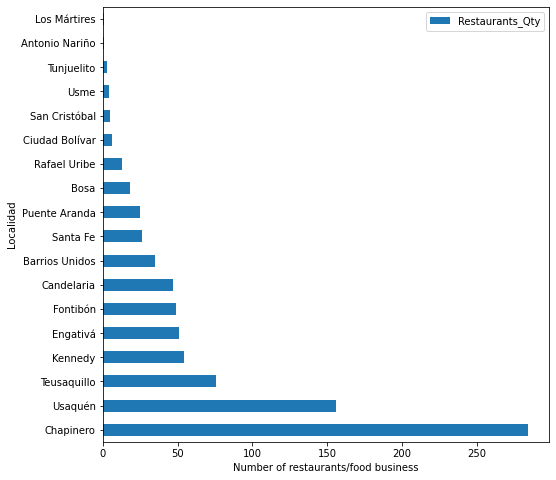

In [37]:
venues_qty_localidad.plot(kind='barh', figsize=(8, 8)) 

plt.xlabel('Number of restaurants/food business')
plt.ylabel('Localidad')

In the following map we can see the geographical location of the _Localidades_. Here, the size of the circles is proportional to the amount of restaurants/food businesses, **the bigger the circle, the higher the number of restaurantes.** 

In [38]:
venues_qty_localidad.reset_index(inplace=True)

In [39]:
# First we join the informatios about the number of restaurants in every Localidad with its geographical info
venues_qty_localidad = venues_qty_localidad.merge(data_localidades, on = 'Localidad')
venues_qty_localidad

,Localidad,Restaurants_Qty,Latitude,Longitude
0,Chapinero,284,4.6569,-74.0467
1,Usaquén,156,4.7485,-74.0312
2,Teusaquillo,76,4.6448,-74.0938
3,Kennedy,54,4.6268,-74.1573
4,Engativá,51,4.7071,-74.1072
5,Fontibón,49,4.6832,-74.1479
6,Barrios Unidos,35,4.6664,-74.0840
7,Santa Fe,26,4.5963,-74.0298
8,Puente Aranda,25,4.6149,-74.1227
9,Bosa,18,4.6305,-74.1945


In [40]:
map_bogota_loc_qty = folium.Map(location=[latitude, longitude], zoom_start=12)



for localidad, lat, lng, qty in zip(venues_qty_localidad['Localidad'], 
                                   venues_qty_localidad['Latitude'], 
                                   venues_qty_localidad['Longitude'],
                                       venues_qty_localidad['Restaurants_Qty']):
    if qty/4 < 3:
        r = 3
    else:
         r = qty/4
    label = str(localidad)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= r,
        popup=label,
        color='red',
        fill=True,
        fill_color='#EAAACD',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota_loc_qty)

map_bogota_loc_qty

#### 3. Amount of restaurants and food businesses by category in Bogotá

In the following graph, we'll see the number of restaurants and food businesses by Category in Bogotá.

In [41]:
venues_qty_categ = bogota_restaurants[['Venue Category','Venue']].groupby('Venue Category').count().sort_values(by = 'Venue' , ascending = False)
venues_qty_categ.rename(columns = {'Venue':"Restaurants_Qty"}, inplace=True)

Text(0.5, 0, 'Category')

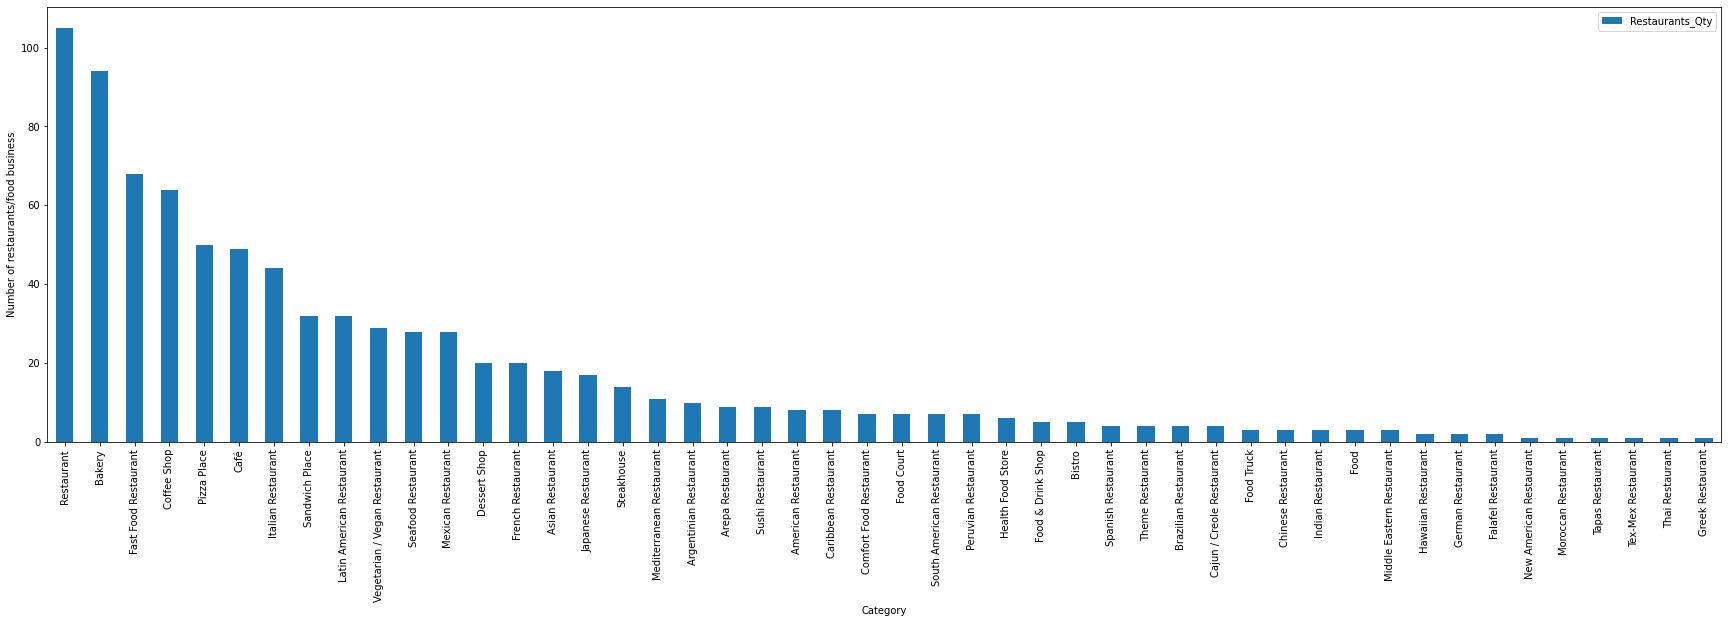

In [42]:
venues_qty_categ.plot(kind='bar', figsize=(30, 8)) 

plt.ylabel('Number of restaurants/food business')
plt.xlabel('Category')

#### 4. Segmentation of the neighbourhoods by type/category of restaurant or food business using k-means method

##### Analizing and preparing the data for the clustering based on the Restaurant and Food Business Categories

* Applying a one hot encoding to the bogota_restaurants data frame

In [43]:
# one hot encoding
bogota_restaurants_onehot = pd.get_dummies(bogota_restaurants[['Venue Category']], prefix="", prefix_sep="")

In [44]:
bogota_restaurants_onehot = pd.concat([bogota_restaurants['Neighbourhood'], bogota_restaurants_onehot], axis=1)
bogota_restaurants_onehot

,Neighbourhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Bakery,Bistro,Brazilian Restaurant,Café,Cajun / Creole Restaurant,...,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
0,Nueva Villemar,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Nueva Villemar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nueva Villemar,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nueva Villemar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Urb. Nueva Granada,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,Armenia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
850,Granjas de Techo,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
851,Granjas de Techo,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
852,Brasil Sector Acacias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Groupping rows by Neighbourhood and taking the mean of the frequency of occurrence of each category

In [45]:
bogota_restaurants_freq = bogota_restaurants_onehot.groupby('Neighbourhood').mean().reset_index()
bogota_restaurants_freq

,Neighbourhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Bakery,Bistro,Brazilian Restaurant,Café,Cajun / Creole Restaurant,...,Seafood Restaurant,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
0,Acapulco_,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
1,Alameda del Sur,0.00000,0.0,0.00000,0.00000,1.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
2,Americas Occidental IV Etapa,0.00000,0.0,0.00000,0.00000,0.250000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
3,Arbolete,0.00000,0.0,0.00000,0.00000,1.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
4,Armenia,0.00000,0.0,0.00000,0.00000,0.100000,0.00000,0.0,0.100000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Villas de Alcalá - Los Cerezos,0.00000,0.0,0.00000,0.00000,0.500000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
137,Villas de San Joaquín,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
138,Villas del Dorado San Antonio,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
139,Visión de Colombia,0.00000,0.0,0.00000,0.00000,0.500000,0.00000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000


* Create the new dataframe and display the top 5 Restaurant and Food Business Categories for each Neighbourhood. At this point we borrow the _return_most_commonvenues_ function from the Segmenting and Clustering Lesson in Applied Data Science Capstone Course (from Applied Data Science Specialization offered by Coursera in partnership with IBM).

In [46]:
def return_most_common_category(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_venues):
    try:
        columns.append('{}{} Most Common Restaurant Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant Type'.format(ind+1))

# create a new dataframe
bogota_restaurant_sorted = pd.DataFrame(columns=columns)
bogota_restaurant_sorted['Neighbourhood'] = bogota_restaurants_freq['Neighbourhood']

for ind in np.arange(bogota_restaurants_freq.shape[0]):
    bogota_restaurant_sorted.iloc[ind, 1:] = return_most_common_category(bogota_restaurants_freq.iloc[ind, :], num_venues)

bogota_restaurant_sorted

,Neighbourhood,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Acapulco_,Fast Food Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Coffee Shop,French Restaurant
1,Alameda del Sur,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
2,Americas Occidental IV Etapa,Fast Food Restaurant,Japanese Restaurant,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
3,Arbolete,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
4,Armenia,Coffee Shop,Italian Restaurant,Restaurant,Indian Restaurant,Bakery
...,...,...,...,...,...,...
136,Villas de Alcalá - Los Cerezos,Pizza Place,Bakery,Coffee Shop,French Restaurant,Food Truck
137,Villas de San Joaquín,Coffee Shop,Theme Restaurant,German Restaurant,French Restaurant,Food Truck
138,Villas del Dorado San Antonio,Mexican Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,French Restaurant,Food Truck
139,Visión de Colombia,Bakery,Dessert Shop,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant


##### Clustering Neighbourhoods


* Run k-means to cluster the neighborhood into 5 clusters


In [48]:
# set number of clusters
kclusters = 5

bogota_clustering = bogota_restaurants_freq.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bogota_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 0, 3, 0, 1, 1, 1, 1, 1, 3, 0, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3,
       1, 3, 2, 1, 0, 1, 1, 3, 0, 1, 4, 2, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 2, 1, 2, 0,
       1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 4, 2, 3, 1, 1, 1, 3, 1, 1, 0, 2, 4, 0, 4, 1,
       1, 2, 1, 1, 1, 2, 1, 4, 1, 3, 2, 4, 3, 1, 1, 1, 1, 0, 2, 3, 0, 2,
       3, 0, 4, 0, 0, 1, 1, 0, 1], dtype=int32)

Check how the data got distributed among the clusters

In [49]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 21, 1: 75, 2: 16, 3: 21, 4: 8}

* Create a new dataframe that includes the cluster as well as the top 5 Restaurant and Food Business Types for each Neghbourhood


In [50]:
# add clustering labels
bogota_restaurant_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [51]:
bogota_restaurant_sorted

,Cluster Labels,Neighbourhood,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,3,Acapulco_,Fast Food Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Coffee Shop,French Restaurant
1,0,Alameda del Sur,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
2,3,Americas Occidental IV Etapa,Fast Food Restaurant,Japanese Restaurant,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
3,0,Arbolete,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
4,1,Armenia,Coffee Shop,Italian Restaurant,Restaurant,Indian Restaurant,Bakery
...,...,...,...,...,...,...,...
136,0,Villas de Alcalá - Los Cerezos,Pizza Place,Bakery,Coffee Shop,French Restaurant,Food Truck
137,1,Villas de San Joaquín,Coffee Shop,Theme Restaurant,German Restaurant,French Restaurant,Food Truck
138,1,Villas del Dorado San Antonio,Mexican Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,French Restaurant,Food Truck
139,0,Visión de Colombia,Bakery,Dessert Shop,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant


In [52]:
# merge bogota_restaurant_sorted with data_neighbourhoods to add latitude/longitude for each neighborhood

bogota_restaurants_categ = data_neighbourhoods.join(bogota_restaurant_sorted.set_index('Neighbourhood'), on='Neighbourhood')
bogota_restaurants_categ

,Neighbourhood,Localidad,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Nueva Villemar,Fontibón,4.671135,-74.136278,1.0,Pizza Place,Coffee Shop,Bakery,Seafood Restaurant,French Restaurant
1,Rincón de Galicia,Ciudad Bolívar,4.587945,-74.174483,NaN,NaN,NaN,NaN,NaN,NaN
2,Urb. Nueva Granada,Chapinero,4.648046,-74.054591,1.0,Restaurant,Bakery,Café,Coffee Shop,Italian Restaurant
3,San Joaquín Vaticano el Vergel,Ciudad Bolívar,4.535340,-74.143060,1.0,Coffee Shop,Theme Restaurant,German Restaurant,French Restaurant,Food Truck
4,Laureles La Estación,Bosa,4.599782,-74.179143,1.0,Arepa Restaurant,Mexican Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
...,...,...,...,...,...,...,...,...,...,...
245,El Tintal A.S.D.,Fontibón,4.657713,-74.128607,1.0,Coffee Shop,Bakery,Comfort Food Restaurant,German Restaurant,French Restaurant
246,S.C. Chico Norte III Sector,Chapinero,4.683160,-74.053605,1.0,Italian Restaurant,Coffee Shop,Sandwich Place,Bakery,Pizza Place
247,Armenia,Teusaquillo,4.618731,-74.072731,1.0,Coffee Shop,Italian Restaurant,Restaurant,Indian Restaurant,Bakery
248,Granjas de Techo,Fontibón,4.642289,-74.116881,0.0,Bakery,Seafood Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,French Restaurant


In [53]:
#dropping the lines corresponding to neighbourhoods with no data about restaurants
bogota_restaurants_categ.dropna(inplace = True)

In [54]:
#casting tha data type on Cluster Labels column
bogota_restaurants_categ.astype({'Cluster Labels': 'int32'})

,Neighbourhood,Localidad,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
0,Nueva Villemar,Fontibón,4.671135,-74.136278,1,Pizza Place,Coffee Shop,Bakery,Seafood Restaurant,French Restaurant
2,Urb. Nueva Granada,Chapinero,4.648046,-74.054591,1,Restaurant,Bakery,Café,Coffee Shop,Italian Restaurant
3,San Joaquín Vaticano el Vergel,Ciudad Bolívar,4.535340,-74.143060,1,Coffee Shop,Theme Restaurant,German Restaurant,French Restaurant,Food Truck
4,Laureles La Estación,Bosa,4.599782,-74.179143,1,Arepa Restaurant,Mexican Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
5,Tayrona,Kennedy,4.640400,-74.157784,1,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant
...,...,...,...,...,...,...,...,...,...,...
245,El Tintal A.S.D.,Fontibón,4.657713,-74.128607,1,Coffee Shop,Bakery,Comfort Food Restaurant,German Restaurant,French Restaurant
246,S.C. Chico Norte III Sector,Chapinero,4.683160,-74.053605,1,Italian Restaurant,Coffee Shop,Sandwich Place,Bakery,Pizza Place
247,Armenia,Teusaquillo,4.618731,-74.072731,1,Coffee Shop,Italian Restaurant,Restaurant,Indian Restaurant,Bakery
248,Granjas de Techo,Fontibón,4.642289,-74.116881,0,Bakery,Seafood Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,French Restaurant


* In the following map we'll see the geographical distribution of the restaurants/food business, colored according with the assigned cluster:
    _red = cluster 0_,
    _purple = cluster 1_,
    _blue = cluster 2_,
    _light green = cluster 3_,
    _orange = cluster 4_.
    

In [55]:
# create map
map_bog_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bogota_restaurants_categ['Latitude'], bogota_restaurants_categ['Longitude'], bogota_restaurants_categ['Neighbourhood'], bogota_restaurants_categ['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_bog_clusters)
       
map_bog_clusters

##### Examine the Clusters

Now, we are going to explore the clusters in order to indentify their characteristics.
Let's start with cluster "0"

* Identify the neightbourhoods included in the cluster and the top 5 Restaurant and Food Business Categories for each Neighbourhood.

In [56]:
bogota_restaurants_cluster0 = bogota_restaurants_categ[bogota_restaurants_categ['Cluster Labels']==0]
bogota_restaurants_cluster0

,Neighbourhood,Localidad,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type
16,Callejón de Santa Bárbara Suroriental,Rafael Uribe,4.556132,-74.115323,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
36,Ciudad Marbella Sector II,San Cristóbal,4.579478,-74.081110,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
58,Urb. San José 2,San Cristóbal,4.578592,-74.087155,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
72,Santa Ana,San Cristóbal,4.574315,-74.081738,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
77,Bosconia,Kennedy,4.649031,-74.144255,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
89,Carmen del Sol I Sector,Rafael Uribe,4.566524,-74.114154,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
93,El Jordán,Usme,4.518949,-74.117828,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant
102,Villas de Alcalá - Los Cerezos,Engativá,4.716778,-74.129343,0.0,Pizza Place,Bakery,Coffee Shop,French Restaurant,Food Truck
124,Granjas de San Pedro,Usme,4.512903,-74.114899,0.0,Bakery,Mexican Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,French Restaurant
129,Alameda del Sur,Rafael Uribe,4.567657,-74.113462,0.0,Bakery,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,German Restaurant,French Restaurant


* Since the clusters were defined based on the restaurants categories, we are going to explore the categories that distinguish any given cluster  

In the following serie _cluster_zero_ we can see the types of restaurants that define the cluster "0"

**Cluster "0"**

In [57]:
cluster_zero = bogota_restaurants_cluster0[['1st Most Common Restaurant Type', '2nd Most Common Restaurant Type', '3rd Most Common Restaurant Type', '4th Most Common Restaurant Type', '5th Most Common Restaurant Type']].melt(var_name='column', value_name='value').value.value_counts()
cluster_zero

Bakery                           21
Vegetarian / Vegan Restaurant    19
French Restaurant                19
Comfort Food Restaurant          18
German Restaurant                17
Coffee Shop                       3
Pizza Place                       2
Dessert Shop                      2
Seafood Restaurant                1
Sandwich Place                    1
Mexican Restaurant                1
Food Truck                        1
Name: value, dtype: int64

* Repeat the exploration for every cluster

**Cluster "1"**

In [58]:
bogota_restaurants_cluster1 = bogota_restaurants_categ[bogota_restaurants_categ['Cluster Labels']==1]
cluster_one = bogota_restaurants_cluster1[['1st Most Common Restaurant Type', '2nd Most Common Restaurant Type', '3rd Most Common Restaurant Type', '4th Most Common Restaurant Type', '5th Most Common Restaurant Type']].melt(var_name='column', value_name='value').value.value_counts()
cluster_one

Coffee Shop                      36
Vegetarian / Vegan Restaurant    32
Bakery                           30
French Restaurant                30
Restaurant                       27
Pizza Place                      22
Fast Food Restaurant             21
German Restaurant                19
Café                             19
Food Truck                       16
Comfort Food Restaurant          12
Sandwich Place                   12
Italian Restaurant               11
Mexican Restaurant                9
Greek Restaurant                  8
Theme Restaurant                  8
Seafood Restaurant                8
Food Court                        7
Dessert Shop                      7
Asian Restaurant                  6
Arepa Restaurant                  5
Latin American Restaurant         5
Cajun / Creole Restaurant         4
Steakhouse                        3
Peruvian Restaurant               2
Argentinian Restaurant            2
Japanese Restaurant               2
Food & Drink Shop           

**Cluster "2"**

In [59]:
bogota_restaurants_cluster2 = bogota_restaurants_categ[bogota_restaurants_categ['Cluster Labels']==2]
cluster_two = bogota_restaurants_cluster2[['1st Most Common Restaurant Type', '2nd Most Common Restaurant Type', '3rd Most Common Restaurant Type', '4th Most Common Restaurant Type', '5th Most Common Restaurant Type']].melt(var_name='column', value_name='value').value.value_counts()
cluster_two

Restaurant                       16
French Restaurant                15
Vegetarian / Vegan Restaurant    15
Coffee Shop                      14
Food Truck                       10
Seafood Restaurant                2
Mediterranean Restaurant          1
Pizza Place                       1
Mexican Restaurant                1
Comfort Food Restaurant           1
Food & Drink Shop                 1
Steakhouse                        1
Bakery                            1
Chinese Restaurant                1
Name: value, dtype: int64

**Cluster "3"**

In [60]:
bogota_restaurants_cluster3 = bogota_restaurants_categ[bogota_restaurants_categ['Cluster Labels']==3]
cluster_three = bogota_restaurants_cluster3[['1st Most Common Restaurant Type', '2nd Most Common Restaurant Type', '3rd Most Common Restaurant Type', '4th Most Common Restaurant Type', '5th Most Common Restaurant Type']].melt(var_name='column', value_name='value').value.value_counts()
cluster_three

Fast Food Restaurant             21
Vegetarian / Vegan Restaurant    15
French Restaurant                14
German Restaurant                11
Coffee Shop                       8
Restaurant                        5
Bakery                            5
Theme Restaurant                  5
Greek Restaurant                  4
Health Food Store                 4
Comfort Food Restaurant           4
Sandwich Place                    2
Seafood Restaurant                1
Japanese Restaurant               1
Mexican Restaurant                1
Pizza Place                       1
Steakhouse                        1
Sushi Restaurant                  1
Chinese Restaurant                1
Name: value, dtype: int64

**Cluster "4"**

In [61]:
bogota_restaurants_cluster4 = bogota_restaurants_categ[bogota_restaurants_categ['Cluster Labels']==4]
cluster_four = bogota_restaurants_cluster4[['1st Most Common Restaurant Type', '2nd Most Common Restaurant Type', '3rd Most Common Restaurant Type', '4th Most Common Restaurant Type', '5th Most Common Restaurant Type']].melt(var_name='column', value_name='value').value.value_counts()
cluster_four

Latin American Restaurant        8
Vegetarian / Vegan Restaurant    8
French Restaurant                8
Food Truck                       4
Greek Restaurant                 4
Comfort Food Restaurant          3
Bakery                           1
Coffee Shop                      1
Mexican Restaurant               1
Sandwich Place                   1
Chinese Restaurant               1
Name: value, dtype: int64

### Results <a class="anchor" id="results"></a>

In order to answer the questions given by our businnes problem, the analysis performed **based on the information available on Foursquare,** has shown that in Bogotá the number of restaurants and food businesses vary widely from one neighbourhood to another, having some neighbourhoods with scarce or none restaurants running, and others with a high amount or restaurants or food businesses operating. The situation is very similar for the _localidades_ (boroughs).<br> 
We have indentified that a high number of restaurants and food service businesses are located in neighbourhoods located on the east and northeast of the city. A similar trend is observed when we analyze the distribution among _Localidades_: The highest number or restaurants are located on the center, east and northeast parts of the city. <br>
Those are the areas where the restaurant and food service industry are already located, so can be identified as potentially interesting neigbourhoods and _Localidades_ for our entrepreneurs to start a new businness, since those are zones where the potencial costumers usually go searching for a place to eat. <br>
On the other hand, the neighbourhoods and _Localidades_ on the south of the city have a much lower number of restaurants on service, which can be a business opportunity for our entrepreneurs, since there may be a demand not being attended yet.<br> 

Regarding of the type of restaurants and food businesses in service, our analysis has shown that bakeries, fast food restaurants, cafes/coffee shops,italian restaurants and pizza places are the most common categories/types of restaurants in the city. There are also a considerable amount of restaurants without a classification (around 15%), and they are shows simply as restaurants, so they can be included in this part of the analysis.<br>
As a result on the clustering performed based on the restaurant type, we have five groups of neighbourhoods/locations, where we can see that bakeries, coffee shops, vegetarian/vegan restaurants are spread all around the city, while fast food restaurants are very common on the center and the southparts of the city. <br> 
This information, all together, could be used to evaluate for a given location the current offer of restaurants, in terms of quantity and type, so the most promising neighborhoods and the best possible location can be chosen.



### Conclusions <a class="anchor" id="conclusions"></a>

The objective of this project was to collect and deliver information about the most promising neighborhoods and the best possible location that can be chosen by those interested in opening a restaurant in Colombia's capital city, Bogotá.<br> 
For this porpouse we had brough together the geographic information of the Bogotá's neighbourhoods ans _Localidades_ with the Foursquare data about the distribution of restaurants and food businesses around the city. From there, through an exploratory analysis, we were able to identify the number of existing restaurants in every neighbourhood and _Localidad_, the number of existing restaurants by type/category, and also we could segmentate the locations into five groups based on the type/category of restaurant or food business. 

With this valuable information our entrepreneurs can make a better decision, based on the potential demand for their products, considering if the neighbourhood is a location already established as a restaurant/food service zone or if there is a demand to be supplied, and taking into account what kind of offer exists in the area, regarding to the type of restaurants on service. 